Using device: cpu
Loading MNIST dataset...
Training samples: 60000
Test samples: 10000

Model architecture:
LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Starting training...
------------------------------------------------------------
Epoch  1/10 | Train Loss: 0.3988 | Train Acc: 88.63% | Test Loss: 0.1129 | Test Acc: 96.54%
Epoch  2/10 | Train Loss: 0.0934 | Train Acc: 97.19% | Test Loss: 0.0656 | Test Acc: 97.83%
Epoch  3/10 | Train Loss: 0.0619 | Train Acc: 98.19% | Test Loss: 0.0539 | Test Acc: 98.16%
Epoch  4/10 | Train Loss: 0.0480 | Train Acc: 98.55% | Test Loss: 0.0436 | Test Acc: 98.51%
Epoch  5/10 | Train Loss: 0.0391 | Train Acc: 98.84% | Te

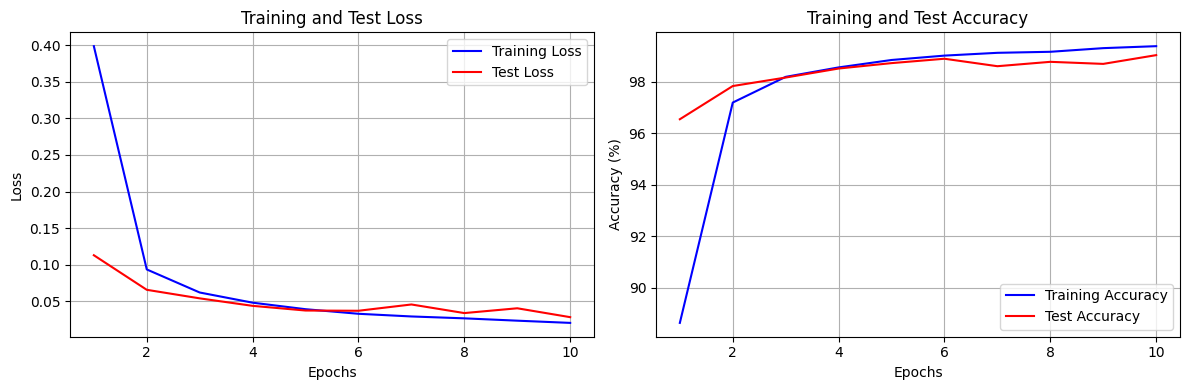

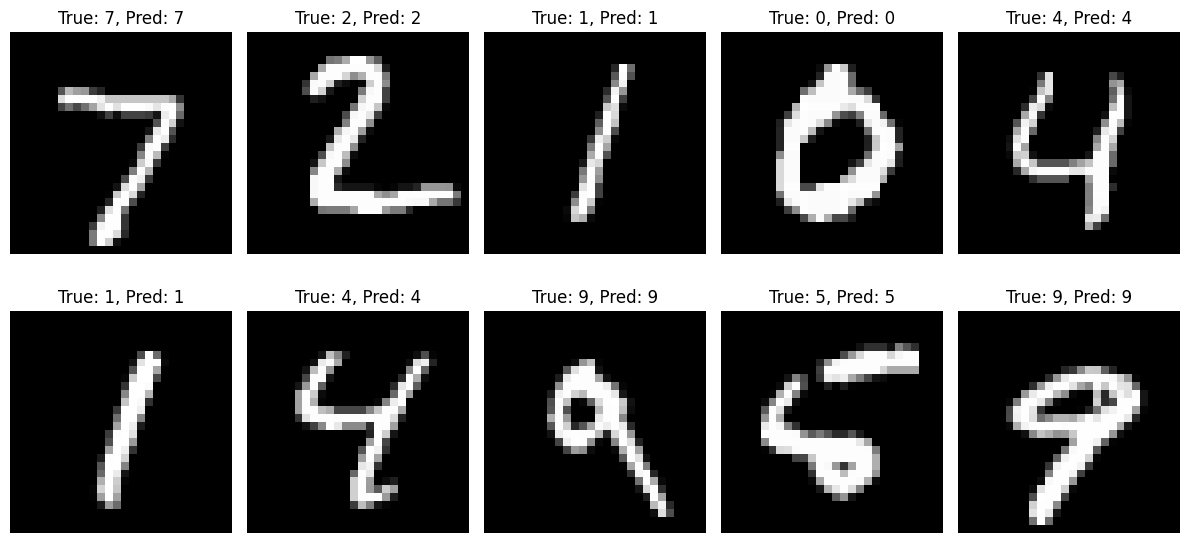

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ====================== MODEL DEFINITION ======================
class LeNet5(nn.Module):
    """
    LeNet-5 architecture for MNIST (28x28 input)
    """
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)  # 28x28 -> 28x28
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)             # 14x14 -> 10x10

        # Pooling layer
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        # First convolutional block
        x = self.pool(F.tanh(self.conv1(x)))      # 28x28 -> 14x14

        # Second convolutional block
        x = self.pool(F.tanh(self.conv2(x)))      # 14x14 -> 5x5

        # Flatten
        x = x.view(-1, 16 * 5 * 5)

        # Fully connected layers
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)

        return x

# ====================== DATA LOADING ======================
def get_data_loaders(batch_size=64):
    """Load MNIST dataset"""

    # Transformations
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
    ])

    # Download and load training data
    train_dataset = datasets.MNIST(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )

    # Download and load test data
    test_dataset = datasets.MNIST(
        root='./data',
        train=False,
        download=True,
        transform=transform
    )

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# ====================== TRAINING FUNCTIONS ======================
def train_epoch(model, train_loader, criterion, optimizer):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        # Forward pass
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

    accuracy = 100. * correct / total
    avg_loss = running_loss / len(train_loader)

    return avg_loss, accuracy

def evaluate(model, test_loader, criterion):
    """Evaluate the model"""
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    accuracy = 100. * correct / total
    avg_loss = test_loss / len(test_loader)

    return avg_loss, accuracy

# ====================== VISUALIZATION ======================
def plot_training_history(history):
    """Plot training and validation curves"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    epochs = range(1, len(history['train_loss']) + 1)

    # Loss plot
    ax1.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    ax1.plot(epochs, history['test_loss'], 'r-', label='Test Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Test Loss')
    ax1.legend()
    ax1.grid(True)

    # Accuracy plot
    ax2.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy')
    ax2.plot(epochs, history['test_acc'], 'r-', label='Test Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Test Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def show_predictions(model, test_loader, num_images=10):
    """Show sample predictions"""
    model.eval()

    # Get batch of test images
    data, target = next(iter(test_loader))
    data, target = data[:num_images].to(device), target[:num_images]

    with torch.no_grad():
        output = model(data)
        _, predicted = output.max(1)

    # Plot images
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    axes = axes.ravel()

    for i in range(num_images):
        axes[i].imshow(data[i].cpu().squeeze(), cmap='gray')
        axes[i].set_title(f'True: {target[i]}, Pred: {predicted[i]}')
        axes[i].axis('off')

        # Color-code based on correctness
        if target[i] == predicted[i]:
            axes[i].set_xlabel('✓', color='green', fontsize=20)
        else:
            axes[i].set_xlabel('✗', color='red', fontsize=20)

    plt.tight_layout()
    plt.show()

# ====================== MAIN TRAINING LOOP ======================
def main():
    # Hyperparameters
    BATCH_SIZE = 64
    LEARNING_RATE = 0.01
    NUM_EPOCHS = 10

    # Load data
    print("Loading MNIST dataset...")
    train_loader, test_loader = get_data_loaders(BATCH_SIZE)
    print(f"Training samples: {len(train_loader.dataset)}")
    print(f"Test samples: {len(test_loader.dataset)}")

    # Initialize model
    model = LeNet5().to(device)
    print(f"\nModel architecture:\n{model}")

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)

    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }

    # Training loop
    print("\nStarting training...")
    print("-" * 60)

    for epoch in range(1, NUM_EPOCHS + 1):
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)

        # Evaluate
        test_loss, test_acc = evaluate(model, test_loader, criterion)

        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)

        # Print progress
        print(f"Epoch {epoch:2d}/{NUM_EPOCHS} | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")

    print("-" * 60)
    print(f"Training completed! Final Test Accuracy: {history['test_acc'][-1]:.2f}%")

    # Visualize results
    plot_training_history(history)
    show_predictions(model, test_loader)


if __name__ == "__main__":
    main()